# Gymnasium Cart Pole

The following notebook provides the implementation of a Reinforcement Learning Agent based on Deep Q-learning.

The agent was implemented with Gymnasium (formerly OpenAI Gym) project, which provides an API for all single agent RL environments.

In detail, I chose the Cart Pole environment, part of the Classic Control set. The agent uses a DQN (Deep Q-Network) to approximate the Q-function, and the Experience Replay technique is implemented.

## Import needed dependencies

In [ ]:
!pip install gymnasium

In [ ]:
!pip install tensorflow

In [ ]:
import gymnasium as gym

import numpy as np
import matplotlib.pyplot as plt

import io
import os
import glob
import base64

In [ ]:
from collections import deque
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
import random

## Video rendering function

This section is intended only for the display in the Google Colab notebook. After installing and importing needed dependencies, the rendering function is designed.

In [ ]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install -U colabgymrender

In [ ]:
!pip install gym-wrappers

In [ ]:
from gym.wrappers.monitoring.video_recorder import VideoRecorder

from IPython.display import HTML
from pyvirtualdisplay import Display
from IPython import display as ipythondisplay


"""
Utility functions to enable video recording of gym environment
and displaying it.
"""

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else:
    print("Could not find video")


def wrap_env(env, path):
  env = VideoRecorder(env, path)
  return env

## DQN implementation

Here it is the implementation of the DQN-based agent, designed as a class. The class contains the model, the epsilon greedy policy and the Experience Replay mechanism.

In [ ]:
class DQN():
    def __init__(self, nS, nA, lr, gamma, eps_max, eps_min, eps_dec):
        self.nS = nS
        self.nA = nA

        # Replay memory
        self.memory = deque([], maxlen=MAX_MEM_SIZE)

        # Training hyperparameters
        self.lr = lr
        self.gamma = gamma
        self.eps = eps_max
        self.eps_min = eps_min
        self.eps_dec = eps_dec

        self.model = self.build_model()

    def build_model(self):

        # DQN architecture
        model = Sequential()
        model.add(Dense(64, input_dim=self.nS, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(self.nA, activation='linear', kernel_initializer='he_uniform'))
        model.compile(optimizer=Adam(learning_rate=self.lr), loss='mse')

        return model

    def action(self, state):

      """Generate a random number from the standard uniform distribution [0,1] and comparing with epsilon.
      If it is lower than epsilon, then randomly select an action between 0 and 1 """

      # Explore with probability epsilon
      if np.random.rand() <= self.eps:
          return random.randrange(self.nA)

      """ Use the DNN to predict the best action from current state """

      # Exploit with probability 1 - epsilon
      # Select action with max Q-value after collecting current approximations of Q(s,a) as returned by NN
      action_values = self.model.predict_on_batch(state)
      return np.argmax(action_values[0])

    # Only testing, so only exploit is possible
    def test_action(self, state):

      # Exploit
      action_values = self.model.predict_on_batch(state)
      return np.argmax(action_values[0])

    # Store the experience in memory, as a tuple of state, action, reward, next state and termination information
    def store(self, state, action, reward, nstate, terminated):
      self.memory.append( (state, action, reward, nstate, terminated) )

    # Experience replay implementation
    def experience_replay(self, batch_size):

      # Sample a random minibatch from memory
      minibatch = random.sample(self.memory, batch_size)

      # Numpy conversion to take advantage of vectorization
      np_mbatch = np.array(minibatch, dtype=object)

      # Creation of state and next state Numpy arrays
      st = np.zeros((0, self.nS))
      nst = np.zeros((0, self.nS))

      for i in range(len(np_mbatch)):
        st = np.append(st, np_mbatch[i, 0], axis = 0)
        nst = np.append(nst, np_mbatch[i, 3], axis = 0)

      # Batch prediction
      st_pre = self.model.predict_on_batch(st)
      nst_pre = self.model.predict_on_batch(nst)

      # Initialize arguments to pass to the model for training
      x = []
      y = []

      for i, (state, action, reward, nstate, terminated) in enumerate(minibatch):

          # Terminal state, just assign reward
          if terminated:
              target = reward

          # Non terminal state, apply Q-learning update
          else:
              # Predict from state
              nst_act_pre = nst_pre[i]

              # Q function update rule
              # Deterministic: q(s,act) = reward + GAMMA * max_a q(s',a)
              target = reward + self.gamma * np.amax(nst_act_pre)

          st_pre[i][action] = target

          # Add values to x and y arrays
          x.append(state)
          y.append(st_pre[i])


      # Convert to Numpy array and reshape for model fit
      x_reshape = np.array(x).reshape(batch_size, self.nS)
      y_reshape = np.array(y)

      # Train network
      # Model fit on states and realtive Q-function values from state
      self.model.fit(x_reshape, y_reshape, verbose=0)
      # Save updated weights
      self.model.save_weights(checkpoint_path)

      # Decay epsilon according to relative factor
      if self.eps > self.eps_min:
          eps_new = self.eps * self.eps_dec
          if eps_new < self.eps_min:
            self.eps = self.eps_min
          else:
            self.eps = eps_new

Now I set the hyperparameters of the model.

In [ ]:
# Setting global variables
MAX_EPISODES = 2000
NUM_EPISODES = 0

# Setting hyperparameters
MAX_MEM_SIZE = 10000  # Maximum experience size
LR = 0.001            # Learning rate
GAMMA = 0.95          # Discount rate
EPS_MAX = 1.00        # Initial exploration probability
EPS_MIN = 0.001       # Final exploration probability
EPS_DEC = 0.995       # Espilon decay factor

BATCH_SIZE = 64

In [ ]:
# File to record network configuration
checkpoint_path = './checkpoints/cp.ckpt'

## CartPole v1

### Environment visualization

Firstly, I analyse the environment, by simply selecting random actions at each step. It is possible to see that the pole does not stay upright.

In [ ]:
root_path = 'video/'
os.mkdir(root_path)

In [ ]:
path = 'video/v1_init.mp4'
os.mknod(path)

In [ ]:
envCartPole = gym.make('CartPole-v1', render_mode="rgb_array")
envCartPole.action_space.seed(50)

display = Display(visible=0, size=(400, 300))
display.start()

# Initialize environment and get related information and observation (current state)
observation, info = envCartPole.reset(seed=50)
w_env = wrap_env(envCartPole, path)

for step in range(500):
    w_env.capture_frame()
    action = envCartPole.action_space.sample()
    observation, reward, terminated, truncated, info = envCartPole.step(action)

    if terminated or truncated:
      observation, info = envCartPole.reset()

w_env.close()
show_video()

/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(


In [ ]:
envCartPole.close()

### Training

After instantiating the environment, the relative number of observations per state and of actions are retrieved.

In [ ]:
# Instantiate environment
envCartPole = gym.make('CartPole-v1')
envCartPole.action_space.seed(50)

# Size of state vector, 4 components
nS = envCartPole.observation_space.shape[0]
# Number of possible actions, 2 for CartPole
nA = envCartPole.action_space.n

The model is created by using the previously set parameters.

In [ ]:
# Agent creation
dqn = DQN(nS, nA, LR, GAMMA, EPS_MAX, EPS_MIN, EPS_DEC)

In [ ]:
# dqn.model.load_weights(checkpoint_path) # Comment out if you want to load weigths from previuos checkpoint

Here it is the training cycle, using the methods provided by the DQN class.

In [ ]:
# Rewards storage
rewards = []
average_rewards = []
# Epsilon storage
epsilons = []

for e in range(MAX_EPISODES):

    observation, info = envCartPole.reset()
    state = np.reshape(observation, [1, nS])
    c_reward = 0

    for time in range(500):

        action = dqn.action(state)
        # Execute action and collect corresponding info
        obs_next, reward, terminated, _, _ = envCartPole.step(action)

        # Collect reward
        c_reward += reward

        # Resize to store in memory
        nstate = np.reshape(obs_next, [1, nS])

        # Store info in memory after reshaping
        dqn.store(state, action, reward, nstate, terminated)
        state = nstate

        # terminated: pole fell, time elapsed: pole stayed upright
        if terminated or time == 499:
            rewards.append(c_reward)
            average_reward = np.round(np.average(rewards[-100:]), decimals=2)
            average_rewards.append(average_reward)
            epsilons.append(dqn.eps)

            print("Episode: {}, reward: {}, epsilon: {}, average reward (last 100 episodes): {}"
                  .format(e + 1, c_reward, np.round(dqn.eps, decimals=4), average_reward))
            # Experience Replay if memory is greater than batch size
            if len(dqn.memory) > BATCH_SIZE:
                  dqn.experience_replay(BATCH_SIZE)
            break



    # The problem can be considered as solved when reaching an average greater than 475 over last 100 episodes
    # Check termination condtion
    if len(rewards) > 100 and np.average(rewards[-100:]) > 475:
        # Set number of episodes
        NUM_EPISODES = e
        break

Episode: 1, reward: 46.0, epsilon: 1.0, average reward (last 100 episodes): 46.0
Episode: 2, reward: 21.0, epsilon: 1.0, average reward (last 100 episodes): 33.5
Episode: 3, reward: 31.0, epsilon: 0.995, average reward (last 100 episodes): 32.67
Episode: 4, reward: 22.0, epsilon: 0.99, average reward (last 100 episodes): 30.0
Episode: 5, reward: 25.0, epsilon: 0.9851, average reward (last 100 episodes): 29.0
Episode: 6, reward: 26.0, epsilon: 0.9801, average reward (last 100 episodes): 28.5
Episode: 7, reward: 25.0, epsilon: 0.9752, average reward (last 100 episodes): 28.0
Episode: 8, reward: 9.0, epsilon: 0.9704, average reward (last 100 episodes): 25.62
Episode: 9, reward: 9.0, epsilon: 0.9655, average reward (last 100 episodes): 23.78
Episode: 10, reward: 16.0, epsilon: 0.9607, average reward (last 100 episodes): 23.0
Episode: 11, reward: 18.0, epsilon: 0.9559, average reward (last 100 episodes): 22.55
Episode: 12, reward: 46.0, epsilon: 0.9511, average reward (last 100 episodes): 2

Now I test the performance of the agent.

In [ ]:
# Test trained agent
TEST_EPISODES = 10

# Only exploitation, no more exploration
for e_test in range(TEST_EPISODES):

    observation, info = envCartPole.reset()
    state = np.reshape(observation, [1, nS])
    c_reward = 0

    for time in range(500):
        action = dqn.test_action(state)
        nstate, reward, terminated, _, _ = envCartPole.step(action)
        nstate = np.reshape( nstate, [1, nS])
        c_reward += reward

        # Do not store anything in memory
        state = nstate

        if terminated or time == 499:
            print("Episode: {}/{}, reward: {}"
                  .format(e_test + 1, TEST_EPISODES, c_reward))
            break;

Episode: 1/10, reward: 500.0
Episode: 2/10, reward: 500.0
Episode: 3/10, reward: 500.0
Episode: 4/10, reward: 500.0
Episode: 5/10, reward: 500.0
Episode: 6/10, reward: 500.0
Episode: 7/10, reward: 500.0
Episode: 8/10, reward: 500.0
Episode: 9/10, reward: 500.0
Episode: 10/10, reward: 500.0


Finally I plot the training evolution of rewards compared with the goal threshold and epsilon decay.

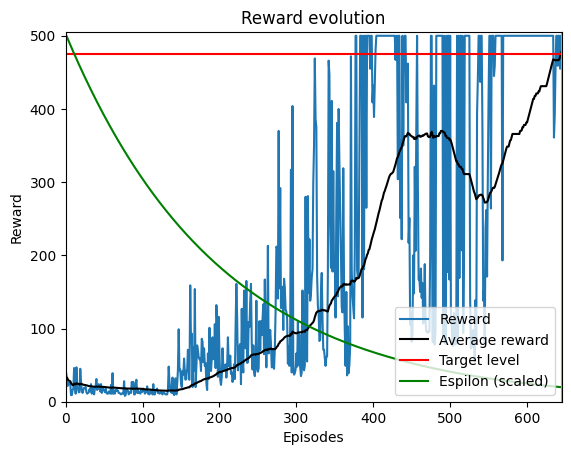

In [ ]:
plt.plot(rewards)
plt.plot(average_rewards, color='black')
plt.axhline(y=475, color='r', linestyle='-')

# Epsilon scaling to match larger reward range
eps_graph = [500*x for x in epsilons]
plt.plot(eps_graph, color='g', linestyle='-')

# Plot the testing lines
plt.axvline(x=NUM_EPISODES, color='y', linestyle='-')
plt.xlim( (0, NUM_EPISODES) )
plt.ylim( (0,505) )


plt.title('Reward evolution')
plt.ylabel('Reward')
plt.xlabel('Episodes')
plt.legend(['Reward', 'Average reward', 'Target level', 'Espilon (scaled)'], loc='lower right')

plt.show()

### Trained agent visualization

To better understand agent performances, I display the environment by executing the actions given by the model. This time, the pole stays upright.

In [ ]:
envCartPole.close()
envCartPole = gym.make('CartPole-v1', render_mode="rgb_array")

In [ ]:
display = Display(visible=0, size=(400, 300))
display.start()

# Initialize environment and get related information and observation (current state)
observation, info = envCartPole.reset(seed=50)
state = np.reshape(observation, [1, nS])
w_env = wrap_env(envCartPole, path)

for step in range(500):
    w_env.capture_frame()
    action = dqn.test_action(state)
    observation, reward, terminated, truncated, info = envCartPole.step(action)
    state = np.reshape(observation, [1, nS])

    if terminated or truncated:
      observation, info = envCartPole.reset()

w_env.close()
show_video()

/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(


In [ ]:
envCartPole.close()

## CartPole v0

For completeness, I also report the same process of training and testing applied on CartPolev0. The instantiated model is the same, as well as other functions. The main difference is the number of steps per episode, that is 200 instead of 500, and hence the goal threshold, that is 195 instead of 475.

### Environment visualization

In [ ]:
path = 'video/v0_init.mp4'
os.mknod(path)

In [ ]:
envCartPole = gym.make('CartPole-v0', render_mode="rgb_array")
envCartPole.action_space.seed(50)

display = Display(visible=0, size=(400, 300))
display.start()

# Initialize environment and get related information and observation (current state)
observation, info = envCartPole.reset(seed=50)
w_env = wrap_env(envCartPole, path)

for step in range(200):
    w_env.capture_frame()
    action = envCartPole.action_space.sample()
    observation, reward, terminated, truncated, info = envCartPole.step(action)

    if terminated or truncated:
      observation, info = envCartPole.reset()

w_env.close()
show_video()

/usr/local/lib/python3.10/dist-packages/gymnasium/envs/registration.py:513: DeprecationWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(


In [ ]:
envCartPole.close()

### Training

In [ ]:
# File to record network configuration
checkpoint_path = './checkpoints/cp.ckpt'

# Instantiate environment
envCartPole = gym.make('CartPole-v0')
envCartPole.action_space.seed(50)

# Size of state vector, 4 components
nS = envCartPole.observation_space.shape[0]
# Number of possible actions, 2 for CartPole
nA = envCartPole.action_space.n

# Agent creation
dqn = DQN(nS, nA, LR, GAMMA, EPS_MAX, EPS_MIN, EPS_DEC)

# dqn.model.load_weights(checkpoint_path) # Comment out if you want to load weigths from previuos checkpoint

In [ ]:
# Rewards storage
rewards = []
average_rewards = []
# Epsilon storage, for Explore/Exploit
epsilons = []

for e in range(MAX_EPISODES):

    observation, info = envCartPole.reset()
    state = np.reshape(observation, [1, nS])
    c_reward = 0

    for time in range(200):

        action = dqn.action(state)
        # Execute action and collect corresponding info
        obs_next, reward, terminated, _, _ = envCartPole.step(action)

        # Collect reward
        c_reward += reward

        # Resize to store in memory
        nstate = np.reshape(obs_next, [1, nS])

        # Store info in memory after reshaping
        dqn.store(state, action, reward, nstate, terminated)
        state = nstate

        # terminated: pole fell, time elapsed: pole stayed upright
        if terminated or time == 199:
            rewards.append(c_reward)
            average_reward = np.round(np.average(rewards[-100:]), decimals=2)
            average_rewards.append(average_reward)
            epsilons.append(dqn.eps)

            print("Episode: {}, reward: {}, epsilon: {}, average reward (last 100 episodes): {}"
                  .format(e + 1, c_reward, np.round(dqn.eps, decimals=4), average_reward))
            # Experience Replay if memory is greater than batch size
            if len(dqn.memory) > BATCH_SIZE:
                  dqn.experience_replay(BATCH_SIZE)
            break



    # The problem can be considered as solved when reaching an average greater than 195 over last 100 episodes
    # Check termination condtion
    if len(rewards) > 100 and np.average(rewards[-100:]) > 195:
        # Set number of episodes
        NUM_EPISODES = e
        break

Episode: 1, reward: 12.0, epsilon: 1.0, average reward (last 100 episodes): 12.0
Episode: 2, reward: 25.0, epsilon: 1.0, average reward (last 100 episodes): 18.5
Episode: 3, reward: 21.0, epsilon: 1.0, average reward (last 100 episodes): 19.33
Episode: 4, reward: 19.0, epsilon: 1.0, average reward (last 100 episodes): 19.25
Episode: 5, reward: 47.0, epsilon: 0.995, average reward (last 100 episodes): 24.8
Episode: 6, reward: 8.0, epsilon: 0.99, average reward (last 100 episodes): 22.0
Episode: 7, reward: 23.0, epsilon: 0.9851, average reward (last 100 episodes): 22.14
Episode: 8, reward: 42.0, epsilon: 0.9801, average reward (last 100 episodes): 24.62
Episode: 9, reward: 29.0, epsilon: 0.9752, average reward (last 100 episodes): 25.11
Episode: 10, reward: 16.0, epsilon: 0.9704, average reward (last 100 episodes): 24.2
Episode: 11, reward: 20.0, epsilon: 0.9655, average reward (last 100 episodes): 23.82
Episode: 12, reward: 15.0, epsilon: 0.9607, average reward (last 100 episodes): 23.0

In [ ]:
# Test trained agent
TEST_EPISODES = 10

# Only exploitation, no more exploration
for e_test in range(TEST_EPISODES):

    observation, info = envCartPole.reset()
    state = np.reshape(observation, [1, nS])
    c_reward = 0

    for time in range(200):
        action = dqn.test_action(state)
        nstate, reward, terminated, _, _ = envCartPole.step(action)
        nstate = np.reshape( nstate, [1, nS])
        c_reward += reward

        # Do not store anything in memory
        state = nstate

        if terminated or time == 199:
            print("Episode: {}/{}, reward: {}"
                  .format(e_test + 1, TEST_EPISODES, c_reward))
            break;

Episode: 1/10, reward: 200.0
Episode: 2/10, reward: 200.0
Episode: 3/10, reward: 200.0
Episode: 4/10, reward: 200.0
Episode: 5/10, reward: 200.0
Episode: 6/10, reward: 200.0
Episode: 7/10, reward: 200.0
Episode: 8/10, reward: 200.0
Episode: 9/10, reward: 200.0
Episode: 10/10, reward: 200.0


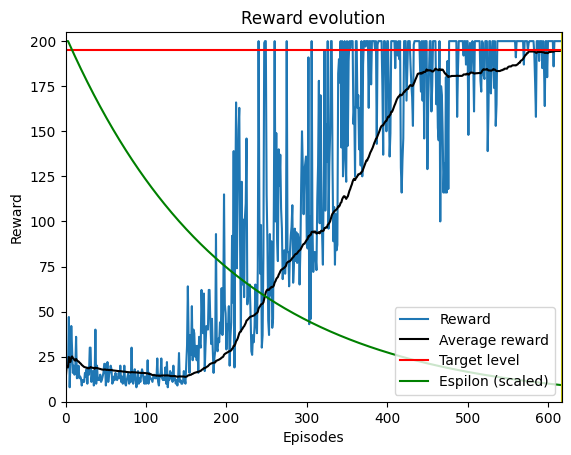

In [ ]:
plt.plot(rewards)
plt.plot(average_rewards, color='black')
plt.axhline(y=195, color='r', linestyle='-')

# Epsilon scaling to match larger reward range
eps_graph = [200*x for x in epsilons]
plt.plot(eps_graph, color='g', linestyle='-')

# Plot the testing lines
plt.axvline(x=NUM_EPISODES, color='y', linestyle='-')
plt.xlim( (0, NUM_EPISODES) )
plt.ylim( (0,205) )


plt.title('Reward evolution')
plt.ylabel('Reward')
plt.xlabel('Episodes')
plt.legend(['Reward', 'Average reward', 'Target level', 'Espilon (scaled)'], loc='lower right')

plt.show()

### Trained agent visualization

In [ ]:
envCartPole.close()
envCartPole = gym.make('CartPole-v0', render_mode="rgb_array")

/usr/local/lib/python3.10/dist-packages/gymnasium/envs/registration.py:523: DeprecationWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.deprecation(


In [ ]:
display = Display(visible=0, size=(400, 300))
display.start()

# Initialize environment and get related information and observation (current state)
observation, info = envCartPole.reset(seed=50)
state = np.reshape(observation, [1, nS])
w_env = wrap_env(envCartPole, path)

for step in range(200):
    w_env.capture_frame()
    action = dqn.test_action(state)
    observation, reward, terminated, truncated, info = envCartPole.step(action)
    state = np.reshape(observation, [1, nS])

    if terminated or truncated:
      observation, info = envCartPole.reset()

w_env.close()
show_video()

/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(


In [ ]:
envCartPole.close()